In [50]:
import pandas as pd 
import numpy as np 
import configparser
import os
import seaborn as sns
import plotly_express as px

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA

import nltk 

from gensim.models import word2vec
from gensim.corpora import Dictionary
from sklearn.manifold import TSNE as tsne

config = configparser.ConfigParser()
config.read("..//env.ini")
data_home = config['DEFAULT']['data_home']
output_dir = config['DEFAULT']['output_dir']
base_path = config['DEFAULT']['base_path']
code_dir = config['DEFAULT']['code_dir']

data_prefix = 'Maha'
out_path = f'{output_dir}/{data_prefix}'
OHCO = ['book_id','chap_id','sec_id','para_num', 'sent_num', 'token_num']


os.chdir(code_dir)
import preprocess
import bow_analysis
os.chdir(base_path + "//notebooks")

SENTS = OHCO[:5]
PARA = OHCO[:4]
SECS = OHCO[:3]
CHAP = OHCO[:2]
BOOK = OHCO[:1]

In [51]:
w2v_params = dict(
    window = 2,
    vector_size = 200,
    min_count = 108, # THIS LIMITS OUR VOCAB
    workers = 8
)

In [52]:
CORPUS = pd.read_csv(fr"{output_dir}\F2\{data_prefix}-CORPUS.csv", sep="|").set_index(OHCO)

VOCAB = pd.read_csv(fr"{output_dir}\CHAP_BOW\{data_prefix}-VOCAB2.csv", sep="|").set_index('term_str')
VOCAB = VOCAB[~VOCAB.index.isna()]
VOCAB

,term_rank,index,n,n_chars,p,i,s,h,stop,stem_porter,...,n_pos,cat_pos,df,idf,dp,di,dh,dfidf,tfidf_mean,tfidf_sum
term_str,,,,,,,,,,,,,,,,,,,,,
the,1,26639,163915,3,6.803053e-02,3.877674,1.469928e+01,0.263800,1,the,...,2,"{'VB', 'DT'}",99.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000
of,2,18678,129501,2,5.374750e-02,4.217659,1.860552e+01,0.226689,1,of,...,1,{'IN'},99.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000
and,3,3003,95887,3,3.979650e-02,4.651215,2.512784e+01,0.185102,1,and,...,1,{'CC'},99.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000
that,4,26637,47382,4,1.966521e-02,5.668211,5.085123e+01,0.111467,1,that,...,6,"{'RB', 'NNP', 'VBP', 'IN', 'WDT', 'DT'}",99.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000
to,5,26929,43192,2,1.792621e-02,5.801786,5.578424e+01,0.104004,1,to,...,1,{'TO'},99.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
jamvunadi,30678,14683,1,9,4.150354e-07,21.200262,2.409433e+06,0.000009,0,jamvunadi,...,1,{'NNP'},1.0,6.629357,0.010101,6.629357,0.066963,6.629357,6.657043e-06,0.000659
jamvuvan,30679,14685,1,8,4.150354e-07,21.200262,2.409433e+06,0.000009,0,jamvuvan,...,1,{'NNP'},1.0,6.629357,0.010101,6.629357,0.066963,6.629357,3.396216e-06,0.000336
janani,30680,14693,1,6,4.150354e-07,21.200262,2.409433e+06,0.000009,0,janani,...,1,{'NN'},1.0,6.629357,0.010101,6.629357,0.066963,6.629357,2.544436e-07,0.000025


In [53]:
BAG = OHCO[:2]

docs = CORPUS.dropna(subset=['term_str'])\
    .groupby(BAG)\
    .term_str.apply(lambda  x:  x.tolist())\
    .reset_index()['term_str'].tolist()

docs = [doc for doc in docs if len(doc) > 1]
docs[:2]

[['anukramanika',
  'parva',
  'om',
  'having',
  'bowed',
  'down',
  'to',
  'narayana',
  'and',
  'nara',
  'the',
  'most',
  'exalted',
  'male',
  'being',
  'and',
  'also',
  'to',
  'the',
  'goddess',
  'saraswati',
  'must',
  'the',
  'word',
  'jaya',
  'be',
  'uttered',
  'ugrasrava',
  'the',
  'son',
  'of',
  'lomaharshana',
  'surnamed',
  'sauti',
  'wellversed',
  'in',
  'the',
  'puranas',
  'bending',
  'with',
  'humility',
  'one',
  'day',
  'approached',
  'the',
  'great',
  'sages',
  'of',
  'rigid',
  'vows',
  'sitting',
  'at',
  'their',
  'ease',
  'who',
  'had',
  'attended',
  'the',
  'twelve',
  'years',
  'sacrifice',
  'of',
  'saunaka',
  'surnamed',
  'kulapati',
  'in',
  'the',
  'forest',
  'of',
  'naimisha',
  'those',
  'ascetics',
  'wishing',
  'to',
  'hear',
  'his',
  'wonderful',
  'narrations',
  'presently',
  'began',
  'to',
  'address',
  'him',
  'who',
  'had',
  'thus',
  'arrived',
  'at',
  'that',
  'recluse',
  'abo

In [54]:
vocab = Dictionary(docs)

In [55]:
vocab

In [56]:
model = word2vec.Word2Vec(docs, **w2v_params)

In [57]:
model.wv.vectors

array([[ 0.33059302,  0.20943221, -0.39149302, ..., -0.10732133,
        -0.38130215, -0.04851124],
       [-0.16524003, -0.18792365, -0.682099  , ..., -0.63100815,
        -0.58426297, -0.16437432],
       [-0.17503901,  0.53380275, -0.14635356, ..., -0.262184  ,
        -0.07108045,  0.08892281],
       ...,
       [ 0.08342905,  0.09973092, -0.10726094, ..., -0.0356085 ,
        -0.09902859, -0.11327494],
       [ 0.03189999,  0.08437472, -0.06849892, ..., -0.10664866,
        -0.1682316 , -0.13122882],
       [-0.040966  ,  0.03197685,  0.00856575, ..., -0.14213301,
        -0.21141912,  0.03867209]], dtype=float32)

In [58]:
def get_vector(row):
    w = row.name
    try:
        vec = model.wv[w]
    except KeyError as e:
        # print(f"No - {w}")
        vec = None
    return vec

WV = pd.DataFrame(VOCAB.apply(get_vector, axis=1).dropna()).apply(lambda x: pd.Series(x[0]), axis=1)
WV

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
term_str,,,,,,,,,,,,,,,,,,,,,
the,0.330593,0.209432,-0.391493,0.511277,0.049593,0.134167,0.372150,0.568134,0.046079,-0.170302,...,-0.530338,0.056175,-0.135899,-0.407858,-0.358445,0.037458,0.047822,-0.107321,-0.381302,-0.048511
of,-0.165240,-0.187924,-0.682099,-0.104624,0.451133,0.207125,-0.555459,-0.804824,-0.235142,0.336552,...,-0.135488,-0.017748,-0.298094,-0.269757,0.164063,-0.277566,-0.139683,-0.631008,-0.584263,-0.164374
and,-0.175039,0.533803,-0.146354,-0.270271,0.363538,0.381712,-0.138845,0.353394,-0.118889,-0.078584,...,0.407873,0.506164,0.042022,0.557576,0.552942,-0.152489,-0.073510,-0.262184,-0.071080,0.088923
that,0.487804,0.054016,0.466195,-0.137925,0.134732,-0.420735,0.385063,0.369475,0.063135,0.279318,...,-0.273741,-0.432411,-0.199715,0.080288,-0.062883,0.399017,-0.339008,-0.007776,0.168309,-0.400972
to,-0.132230,-0.093701,0.059596,0.608925,0.858479,0.070241,0.578932,-0.544158,-0.494181,1.030116,...,-1.048109,0.316271,0.977786,0.682826,0.042858,-0.002259,-0.564624,0.617350,1.261324,0.517398
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
kali,0.083429,0.099731,-0.107261,0.164051,0.021975,0.104433,0.050997,0.331174,-0.026622,0.101274,...,-0.002259,0.040849,-0.093295,0.044413,0.032016,0.052290,0.004833,-0.035609,-0.099029,-0.113275
shame,-0.040966,0.031977,0.008566,0.205120,0.061902,0.192728,0.136547,0.344201,-0.014002,0.124773,...,0.123029,0.134980,-0.061010,0.076675,0.014401,0.169789,0.049795,-0.142133,-0.211419,0.038672
increase,0.018406,0.003484,0.017016,0.030159,0.072895,0.025229,0.111494,0.160031,-0.042627,0.023396,...,0.174846,0.024126,-0.072310,0.011901,0.020148,0.128608,-0.039756,-0.106798,-0.115391,-0.027741


In [59]:
WV.to_csv(fr"{output_dir}/Word2Vec_Results/{data_prefix}-W2V.csv", sep="|")

In [60]:
PP = 108
tsne_engine = tsne(
    perplexity=PP, 
    n_components=2, 
    init='pca', 
    n_iter=2500, 
    random_state=108)

In [61]:
tsne_model = tsne_engine.fit_transform(WV.to_numpy())

C:\Users\vishg\AppData\Roaming\Python\Python312\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning:

'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.



In [62]:
TSNE = pd.DataFrame(tsne_model, columns=['x','y'], index=WV.index)
TSNE

,x,y
term_str,,
the,6.463146,-7.103108
of,1.738158,2.778850
and,9.704630,-2.916798
that,-8.303814,-7.360894
to,-16.814375,7.816029
...,...,...
kali,2.301072,-7.673518
shame,0.375181,-0.717477
increase,-4.282770,3.085003


In [63]:
TSNE.reset_index()[TSNE.reset_index()['term_str'].apply(lambda x: x[:3]=='div')]

,term_str,x,y
213,diverse,16.156195,-2.395364
745,divine,2.668765,-6.654493
1100,division,7.954418,2.220317
1134,divested,-3.086001,9.432993
1295,divisions,8.749084,-6.632681


In [64]:
X = TSNE.join(VOCAB, how='left')
X = X[X['max_pos_group']=='RB']
px.scatter(X.reset_index(), 'x', 'y', 
        text='term_str', 
        color='max_pos_group', 
        hover_name='term_str',          
        height=1000,
        width=1200)\
    .update_traces(
        mode='markers+text', 
        textfont=dict(color='black', size=14, family='Arial'),
        textposition='top center')

In [65]:
X = TSNE.join(VOCAB, how='left')
X = X[X['max_pos_group']=='JJ']
px.scatter(X.reset_index(), 'x', 'y', 
        text='term_str', 
        color='max_pos_group', 
        hover_name='term_str',          
        height=1000,
        width=1200)\
    .update_traces(
        mode='markers+text', 
        textfont=dict(color='black', size=14, family='Arial'),
        textposition='top center')

In [66]:
X = TSNE.join(VOCAB, how='left')
X = X[X['max_pos_group']=='NN']
px.scatter(X.reset_index(), 'x', 'y', 
        text='term_str', 
        color='max_pos_group', 
        hover_name='term_str',          
        height=1000,
        width=1200)\
    .update_traces(
        mode='markers+text', 
        textfont=dict(color='black', size=14, family='Arial'),
        textposition='top center')

In [67]:
X = TSNE.join(VOCAB, how='left')
px.scatter(X.reset_index(), 'x', 'y', 
           title="t-SNE Reduced Plot of Word2Vec Embeddings",
        text='term_str', 
        size="dfidf",
        # color='max_pos_group', 
        hover_name='term_str',          
        height=1000,
        width=1200)\
    .update_traces(
        mode='markers+text', 
        textfont=dict(color='black', size=14, family='Arial'),
        textposition='top center')

In [68]:
def complete_analogy(A, B, C, n=2):
    try:
        cols = ['term', 'sim']
        return pd.DataFrame(model.wv.most_similar(positive=[B, C], negative=[A])[0:n], columns=cols)
    except KeyError as e:
        print('Error:', e)
        return None
    
def get_most_similar(positive, negative=None):
    return pd.DataFrame(model.wv.most_similar(positive, negative), columns=['term', 'sim'])

In [69]:
get_most_similar('defeat',3)

,term,sim
0,kingdom,0.604079
1,fears,0.591995
2,welfare,0.564947
3,protection,0.561697
4,foe,0.545687
5,lives,0.544350
6,business,0.542924
7,purpose,0.542477
8,wishes,0.537511
9,journey,0.537351


In [70]:
complete_analogy('man', 'prince', 'woman', 5)

,term,sim
0,princess,0.796534
1,host,0.748195
2,daughter,0.722365
3,descendant,0.717095
4,queen,0.714625


In [71]:
import sys
sys.path.append(code_dir)
from hac2 import HAC

<Figure size 640x480 with 0 Axes>

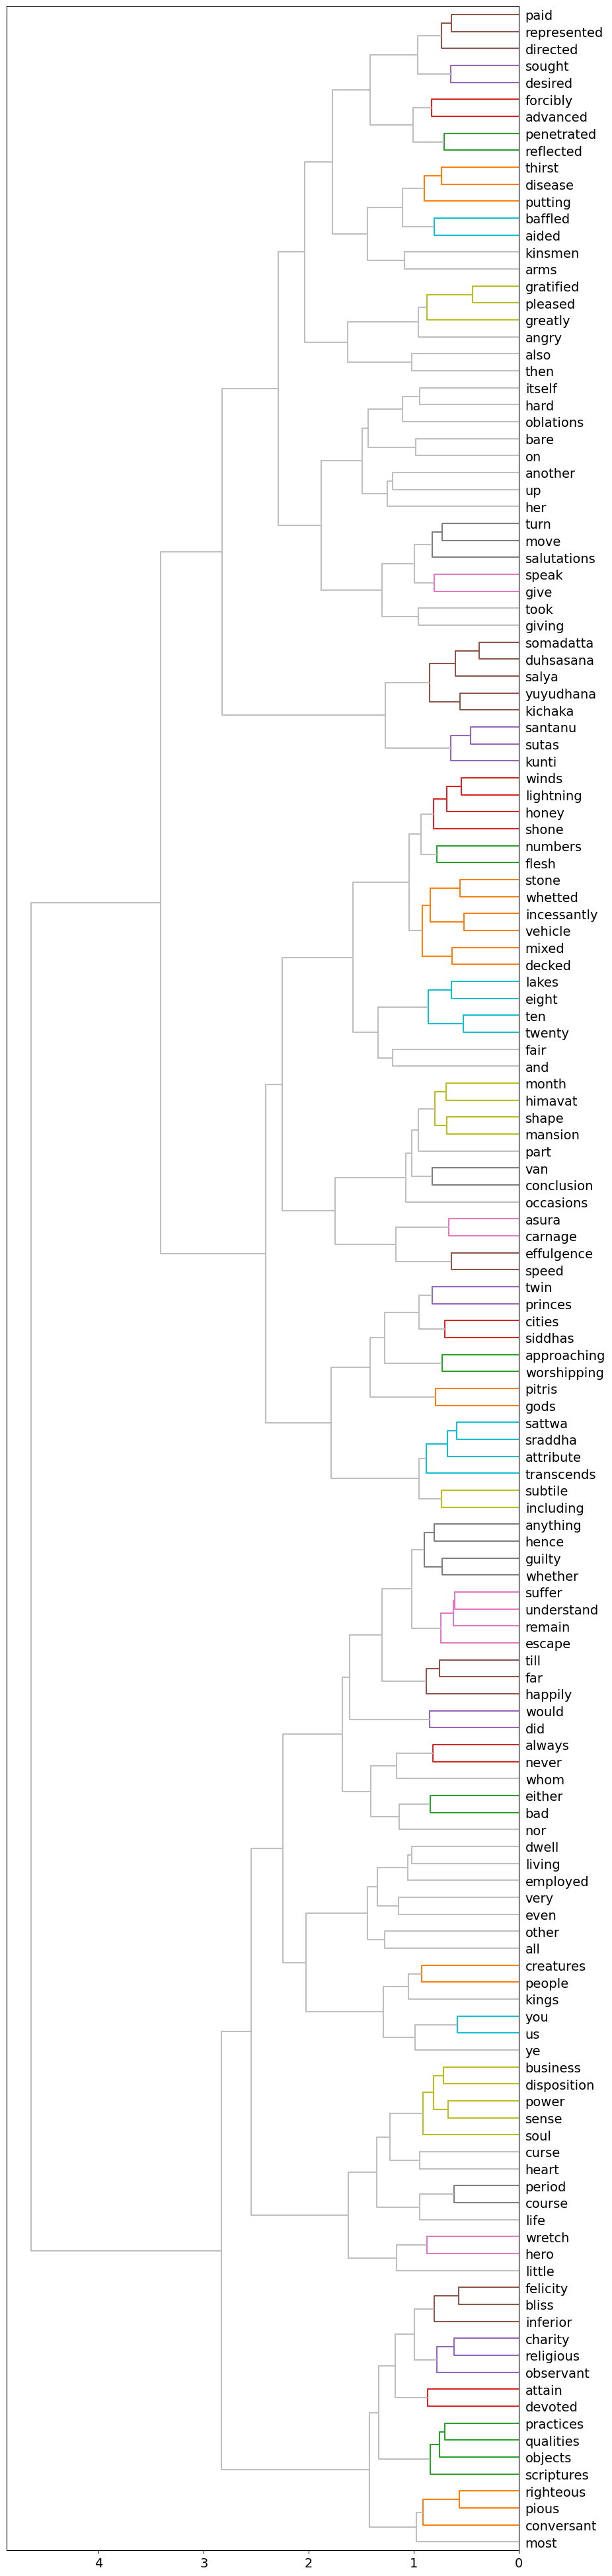

In [72]:
HAC(WV.sample(150)).plot()